#**2023-2학기 인공지능 기말 프로젝트**
---
> 컴퓨터학부 2020218072 조홍석











##Environment

- COLAB PRO, GPU: A100 , 고용량 RAM

##Library version check

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 9.0 MB/s eta 0:00:00


In [3]:
import sys
import tqdm as tq
import xgboost as xgb
import lightgbm as lgb
import catboost as cat
import matplotlib
import seaborn as sns
import sklearn as skl
import pandas as pd
import numpy as np
print("-------------------------- Python & library version --------------------------")
print("Python version: {}".format(sys.version))
print("pandas version: {}".format(pd.__version__))
print("numpy version: {}".format(np.__version__))
print("matplotlib version: {}".format(matplotlib.__version__))
print("tqdm version: {}".format(tq.__version__))
print("xgboost version: {}".format(xgb.__version__))
print("lightgbm version: {}".format(lgb.__version__))
print("catboost version: {}".format(cat.__version__))
print("seaborn version: {}".format(sns.__version__))
print("scikit-learn version: {}".format(skl.__version__))
print("------------------------------------------------------------------------------")

-------------------------- Python & library version --------------------------
Python version: 3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0]
pandas version: 1.5.3
numpy version: 1.23.5
matplotlib version: 3.7.1
tqdm version: 4.66.1
xgboost version: 2.0.2
lightgbm version: 4.1.0
catboost version: 1.2.2
seaborn version: 0.12.2
scikit-learn version: 1.2.2
------------------------------------------------------------------------------




#**Dataset Info.**
[대구 교통사고 피해 예측 AI 경진대회](https://dacon.io/competitions/official/236193/overview/description) 에서 제공하는 데이터를 활용
- train.csv
  - ID : 대구에서 발생한 교통사고의 고유 ID
  - 2019년부터 2021년까지의 교통사고 데이터로 구성
  - 해당 사고가 발생한 당시의 시공간 정보와 사고 관련 정보 포함
  - ECLO : 인명피해 심각도

- test.csv
  - ID : 대구에서 발생한 교통사고의 고유 ID
  - 2022년도의 교통사고 데이터로 구성
  - 추론 시점에서 획득할 수 있는 정보로 구성



- sample_submission.csv
  - ID : 추론 샘플의 고유 ID
  - ECLO : 예측한 인명피해 심각도
---

### 외부데이터
- 대구 빅데이터 마트 데이터
  - 대구 빅데이터활용센터에서 구축한 빅데이터 마트 데이터 중 제공 가능한 일부 데이터셋
  - 상세한 명세는 폴더 내부의 빅데이터 마트 데이터 설명서.hwp 참고
  - 전체 빅데이터 마트 데이터셋을 활용하기 위해서는 대구 빅데이터활용센터를   - 직접 방문하여 사내망 사용


- countrywide_accident.csv
  - 대구를 제외한 전국에서 발생한 교통사고 데이터
  - 2019년부터 2021년까지의 교통사고 데이터로 구성
  - train.csv와 양식 동일


- 대구 보안등 정보.csv
  - 대구에 존재하는 보안등 관련 정보
  - 대구에 존재하는 어린이 보호 구역 관련 정보


- 대구 주차장 정보.csv  
  - 대구에 존재하는 주차장 관련 정보


- 대구 CCTV 정보.csv  
  - 대구에 존재하는 CCTV 관련 정보
  - 도로노선방향
    - 01 : 상행
    - 02 : 하행
    - 03 : 양방향
- 단속구분
    - 01 : 속도
    - 02 : 신호
    - 03 : 통행위반
    - 04 : 불법주정차
    - 99 : 기타
- 단속구간위치구분
    - 01 : 시점
    - 02 : 종점
- 보호구역구분
    - 01 : 노인보호구역
    - 02 : 어린이보호구역
    - 99 : 기타

#Library

In [ ]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-nanum is already the newest version (20200506-1).
0 upgraded, 0 newly installed, 0 to remove and 23 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 39 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/truetype/humor-sans: skipping, looped directory detected
/usr/share/fonts/truetype/liberation: skipping, looped directory detected
/usr/share/fonts/truetype/

In [ ]:
exit()

In [ ]:
import matplotlib.pyplot as plt

plt.rc('font', family='NanumGothic')

In [ ]:
import warnings
warnings.filterwarnings('ignore')

rc('font', family='NanumGothic')
plt.rcParams['axes.unicode_minus'] = False

In [ ]:
#Regression
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
from matplotlib import rc
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

rc('font', family='NanumGothic')
plt.rcParams['axes.unicode_minus'] = False

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Dataset

In [ ]:
path = '/content/drive/MyDrive/[Dacon]/대구 교통사고 피해 예측 AI 경진대회/open/open'

train = pd.read_csv(path + '/train.csv')
test = pd.read_csv(path + '/test.csv')
ss = pd.read_csv(path + '/sample_submission.csv')

train.drop(['ID'],axis=1, inplace=True)
test.drop(['ID'],axis=1, inplace=True)
#external

#EDA 및 시각화

In [ ]:
def wrangling(train_set, test_set):

    print("---Shape---")
    display(train_set.shape)
    display(test_set.shape)

    print("---Info----")
    display(train_set.info())
    display(test_set.info())

    print("---NaN----")
    display(train_set.isna().sum())
    display(test_set.isna().sum())

    print("---Duplicated---")
    display(train_set[train_set.duplicated()])
    display(test_set[test_set.duplicated()])

    print("---Description---")
    display(train_set.describe())
    display(test_set.describe())

    print("---Unique---")
    display(train_set.nunique())
    display(test_set.nunique())

wrangling(train,test)

---Shape---


(39609, 22)

(10963, 7)

---Info----
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39609 entries, 0 to 39608
Data columns (total 22 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   사고일시         39609 non-null  object
 1   요일           39609 non-null  object
 2   기상상태         39609 non-null  object
 3   시군구          39609 non-null  object
 4   도로형태         39609 non-null  object
 5   노면상태         39609 non-null  object
 6   사고유형         39609 non-null  object
 7   사고유형 - 세부분류  39609 non-null  object
 8   법규위반         39609 non-null  object
 9   가해운전자 차종     39609 non-null  object
 10  가해운전자 성별     39609 non-null  object
 11  가해운전자 연령     39609 non-null  object
 12  가해운전자 상해정도   39609 non-null  object
 13  피해운전자 차종     38618 non-null  object
 14  피해운전자 성별     38618 non-null  object
 15  피해운전자 연령     38618 non-null  object
 16  피해운전자 상해정도   38618 non-null  object
 17  사망자수         39609 non-null  int64 
 18  중상자수         39609 non-null  int64 
 19  경상자수         

None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10963 entries, 0 to 10962
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   사고일시    10963 non-null  object
 1   요일      10963 non-null  object
 2   기상상태    10963 non-null  object
 3   시군구     10963 non-null  object
 4   도로형태    10963 non-null  object
 5   노면상태    10963 non-null  object
 6   사고유형    10963 non-null  object
dtypes: object(7)
memory usage: 599.7+ KB


None

---NaN----


사고일시             0
요일               0
기상상태             0
시군구              0
도로형태             0
노면상태             0
사고유형             0
사고유형 - 세부분류      0
법규위반             0
가해운전자 차종         0
가해운전자 성별         0
가해운전자 연령         0
가해운전자 상해정도       0
피해운전자 차종       991
피해운전자 성별       991
피해운전자 연령       991
피해운전자 상해정도     991
사망자수             0
중상자수             0
경상자수             0
부상자수             0
ECLO             0
dtype: int64

사고일시    0
요일      0
기상상태    0
시군구     0
도로형태    0
노면상태    0
사고유형    0
dtype: int64

---Duplicated---


,사고일시,요일,기상상태,시군구,도로형태,노면상태,사고유형,사고유형 - 세부분류,법규위반,가해운전자 차종,...,가해운전자 상해정도,피해운전자 차종,피해운전자 성별,피해운전자 연령,피해운전자 상해정도,사망자수,중상자수,경상자수,부상자수,ECLO
3360,2019-04-05 11,금요일,맑음,대구광역시 수성구 매호동,단일로 - 기타,건조,차대차,측면충돌,안전운전불이행,승용,...,상해없음,승용,여,37세,경상,0,0,1,0,3


,사고일시,요일,기상상태,시군구,도로형태,노면상태,사고유형
758,2022-01-27 13,목요일,맑음,대구광역시 동구 효목동,교차로 - 교차로안,건조,차대차
994,2022-02-07 07,월요일,맑음,대구광역시 서구 내당동,단일로 - 기타,건조,차대차
1185,2022-02-14 17,월요일,맑음,대구광역시 남구 봉덕동,단일로 - 기타,건조,차대차
1633,2022-03-03 08,목요일,맑음,대구광역시 서구 비산동,단일로 - 기타,건조,차대차
2527,2022-04-06 08,수요일,맑음,대구광역시 북구 태전동,교차로 - 교차로안,건조,차대차
3246,2022-04-29 08,금요일,비,대구광역시 달서구 상인동,단일로 - 기타,젖음/습기,차대차
3330,2022-05-01 18,일요일,맑음,대구광역시 달서구 송현동,단일로 - 기타,건조,차대차
3360,2022-05-02 20,월요일,비,대구광역시 달서구 상인동,교차로 - 교차로안,젖음/습기,차대차
3817,2022-05-15 15,일요일,맑음,대구광역시 수성구 만촌동,단일로 - 기타,건조,차대차
3888,2022-05-17 17,화요일,맑음,대구광역시 북구 노원동3가,단일로 - 기타,건조,차대차


---Description---


,사망자수,중상자수,경상자수,부상자수,ECLO
count,39609.000000,39609.000000,39609.000000,39609.000000,39609.000000
mean,0.007776,0.262365,1.070085,0.126865,4.726704
std,0.090109,0.500845,0.992034,0.394670,3.207206
min,0.000000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,0.000000,0.000000,0.000000,3.000000
50%,0.000000,0.000000,1.000000,0.000000,3.000000
75%,0.000000,0.000000,1.000000,0.000000,6.000000
max,2.000000,6.000000,22.000000,10.000000,74.000000


,사고일시,요일,기상상태,시군구,도로형태,노면상태,사고유형
count,10963,10963,10963,10963,10963,10963,10963
unique,5548,7,5,192,11,6,3
top,2022-11-10 18,금요일,맑음,대구광역시 남구 대명동,단일로 - 기타,건조,차대차
freq,10,1743,10321,422,5039,10394,8559


---Unique---


사고일시           18057
요일                 7
기상상태               6
시군구              199
도로형태              11
노면상태               6
사고유형               3
사고유형 - 세부분류       14
법규위반              11
가해운전자 차종          12
가해운전자 성별           3
가해운전자 연령          89
가해운전자 상해정도         6
피해운전자 차종          13
피해운전자 성별           3
피해운전자 연령          97
피해운전자 상해정도         6
사망자수               3
중상자수               7
경상자수              18
부상자수               9
ECLO              46
dtype: int64

사고일시    5548
요일         7
기상상태       5
시군구      192
도로형태      11
노면상태       6
사고유형       3
dtype: int64

In [ ]:
#변수형 변경
import re
def extract_and_convert_to_int(data):
    numbers = re.findall(r'\d+', str(data))
    return int(numbers[0]) if numbers else np.nan

train['가해운전자 연령'] = train['가해운전자 연령'].apply(extract_and_convert_to_int)
train['피해운전자 연령'] = train['피해운전자 연령'].apply(extract_and_convert_to_int)

In [ ]:
num_cols = train.select_dtypes(exclude='object').columns.tolist()
cat_cols = train.select_dtypes(include='object').columns.tolist()

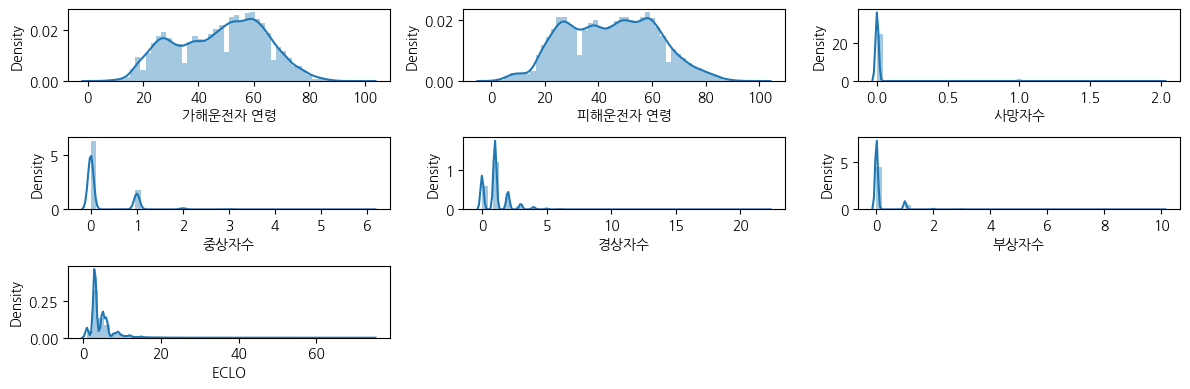

In [ ]:
i = 0
plt.figure(figsize=(12,4))
for col in num_cols:
    i += 1
    plt.subplot(3,3,i)
    sns.distplot(train[col])
plt.tight_layout()

**Insight**

- 사망까지 이른 경우는 많지 않지만 치명적인 사고가 됨
- 부상자수가 높았던 사건이 있음

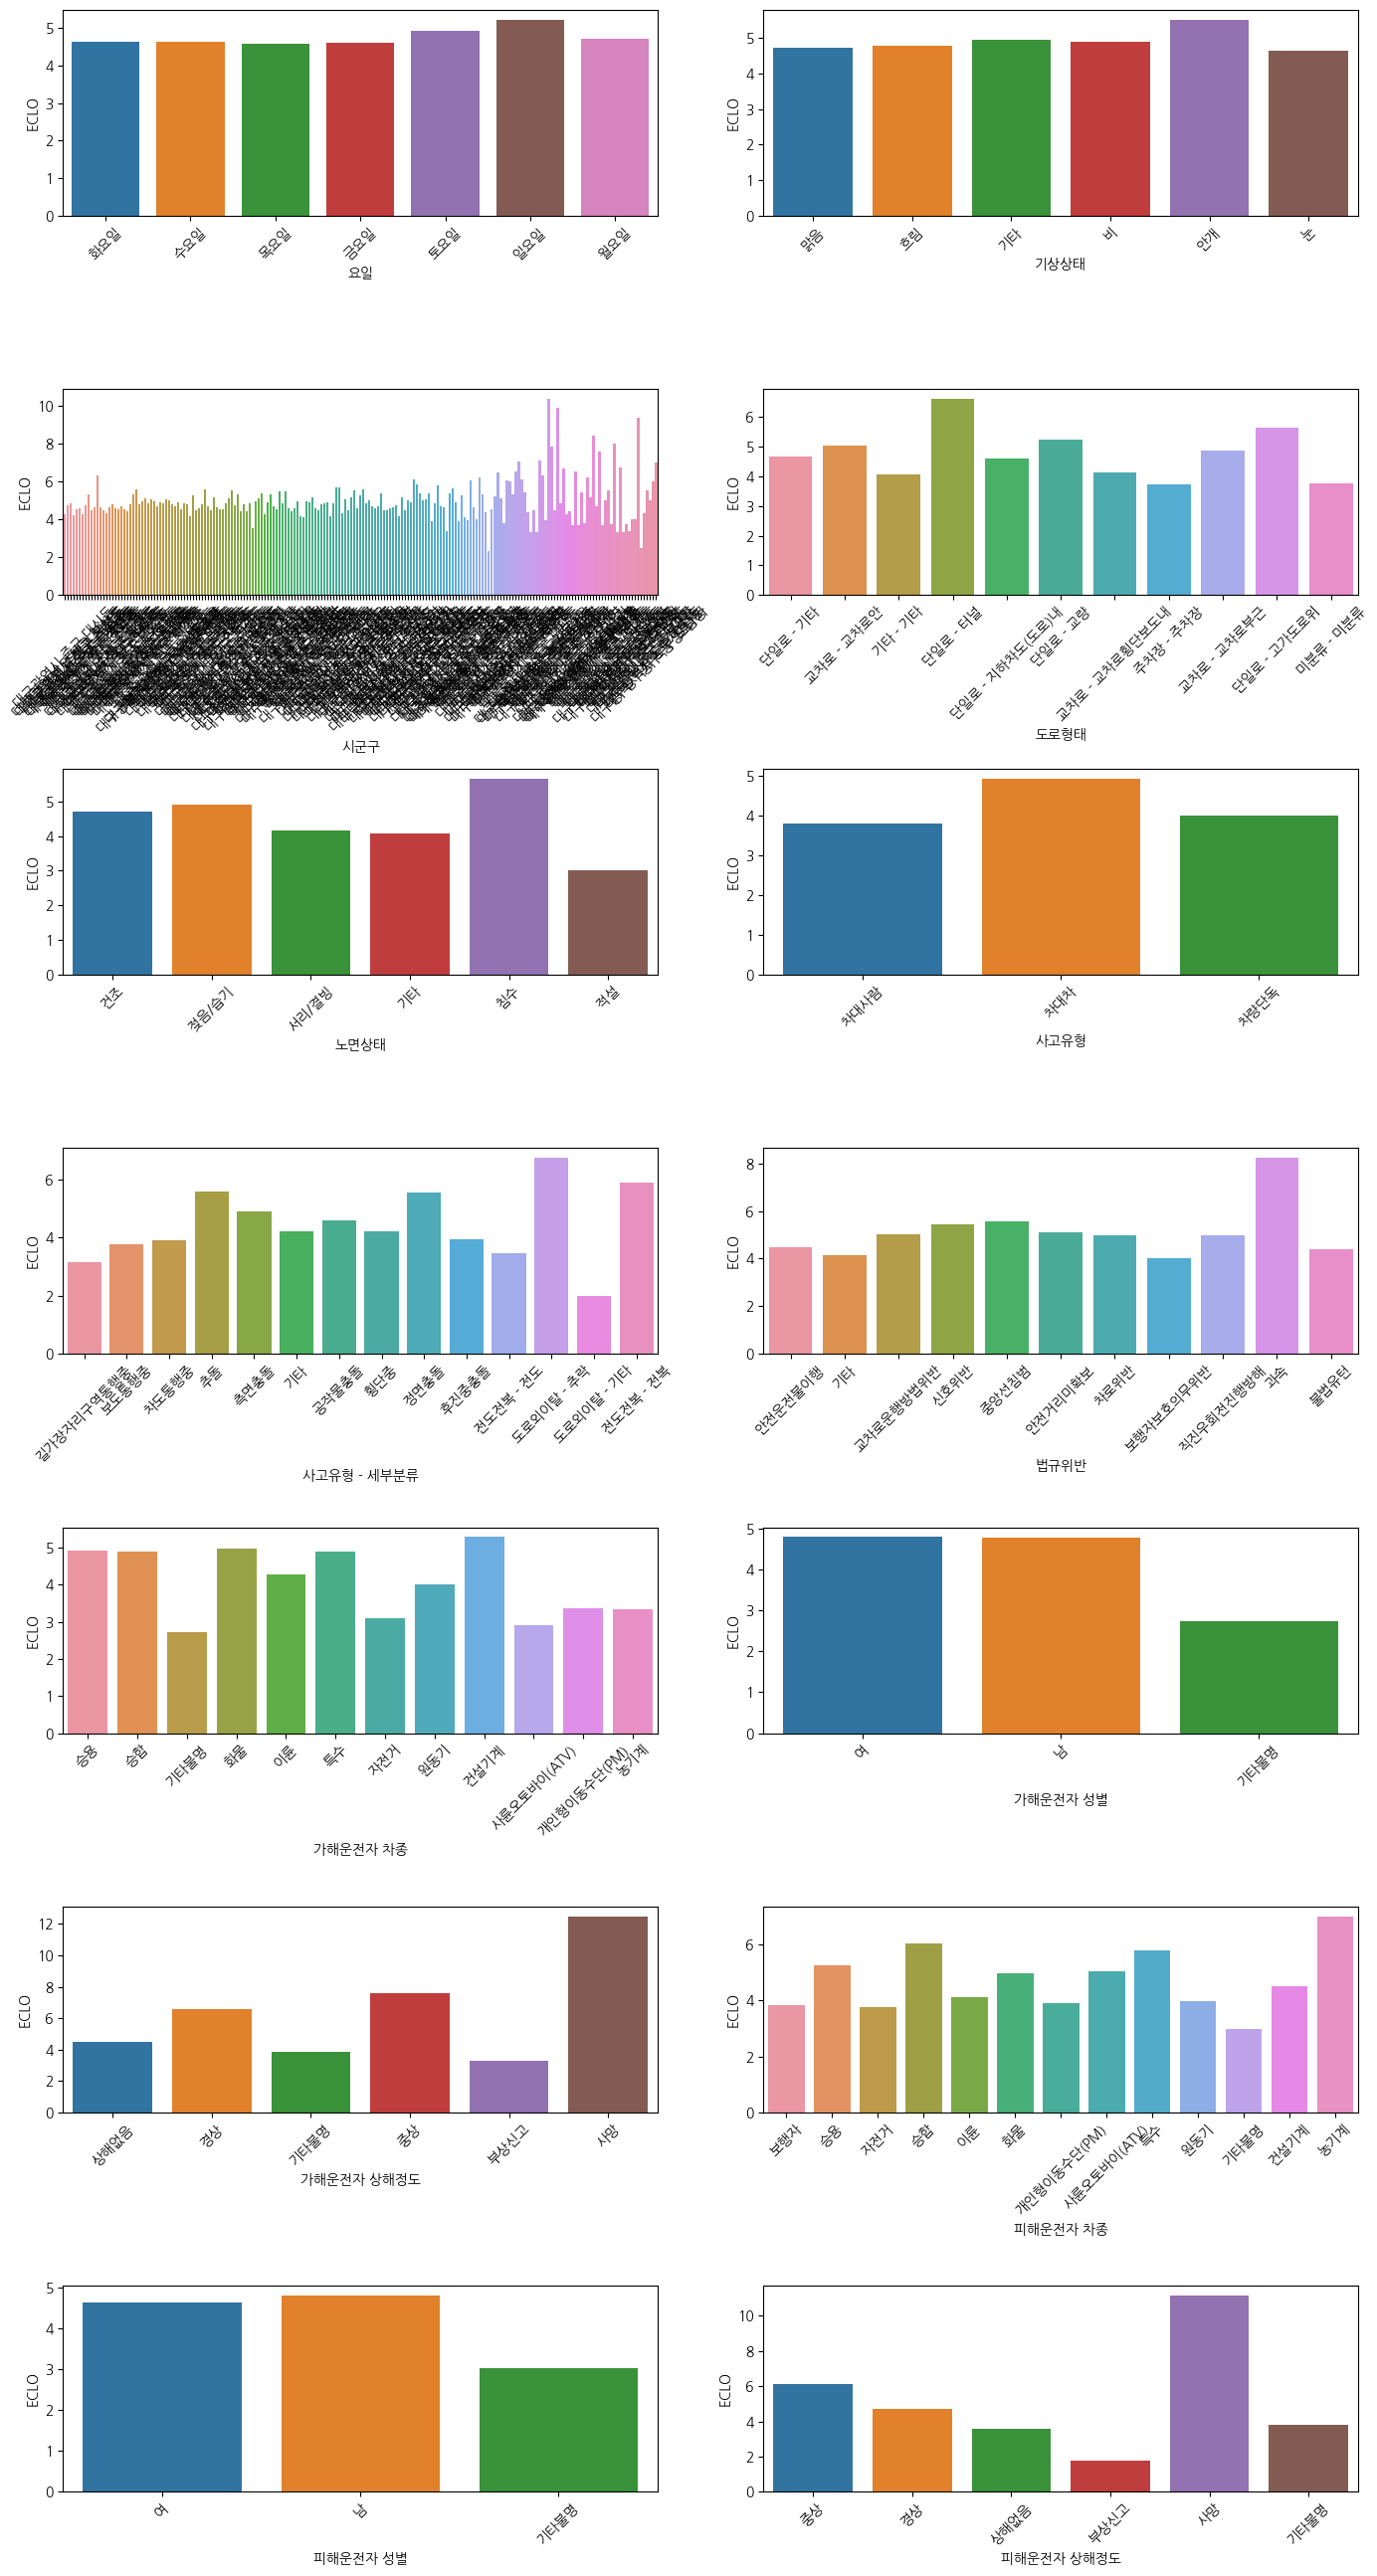

In [ ]:
i = 0
plt.figure(figsize=(14,26))
for col in ['요일',
 '기상상태',
 '시군구',
 '도로형태',
 '노면상태',
 '사고유형',
 '사고유형 - 세부분류',
 '법규위반',
 '가해운전자 차종',
 '가해운전자 성별',
 '가해운전자 상해정도',
 '피해운전자 차종',
 '피해운전자 성별',
 '피해운전자 상해정도']:
    i += 1
    plt.subplot(7,2,i)
    sns.barplot(x=train[col], y=train['ECLO'],ci=None)
    plt.xticks(rotation=45)
plt.tight_layout()

**Insight**

- 토요일, 일요일의 경우 보다 ECLO가 높음
- 안개가 낀 상황에 ECLO가 높음
- 특정 시군구에서 ECLO가 높음
- 단일로 - 터널의 경우 ECLO가 높음
- 노면상태가 침수인 경우 ECLO가 높았으며 반대로, 적설인 경우 ECLO가 낮음
- 차vs사람 보다 차vs차일 때 ECLO가 높음
- 법규위반이 과속인 경우 ECLO가 높음
- 가해운전자 차종이 승용, 승합, 화물, 건설기계인 경우 ECLO가 높음
- 가해운전자 성별에 따른 차이는 보이지 않음
- 피해운전자 차종이 농기계인 경우 ECLO가 높음

# Hypothesis

## 어느 시군구에서 ECLO가 높고 낮았을까?

In [ ]:
num_by_region = train.groupby(['시군구'])['ECLO'].mean().sort_values(ascending=False)
print("높은 ECLO")
display(num_by_region[:10])
print()
print("낮은 ECLO")
display(num_by_region[-10:])

높은 ECLO


시군구
대구광역시 북구 노곡동    10.333333
대구광역시 동구 덕곡동     9.875000
대구광역시 중구 대안동     9.333333
대구광역시 동구 내동      8.400000
대구광역시 중구 하서동     8.000000
대구광역시 동구 진인동     7.823529
대구광역시 동구 둔산동     7.571429
대구광역시 북구 조야동     7.120000
대구광역시 동구 송정동     7.071429
대구광역시 북구 도남동     7.000000
Name: ECLO, dtype: float64


낮은 ECLO


시군구
대구광역시 동구 매여동      3.666667
대구광역시 중구 삼덕동1가    3.511013
대구광역시 중구 향촌동      3.400000
대구광역시 중구 수창동      3.392857
대구광역시 중구 서성로2가    3.333333
대구광역시 중구 북성로1가    3.333333
대구광역시 중구 화전동      3.333333
대구광역시 동구 미대동      3.300000
대구광역시 중구 종로2가     2.500000
대구광역시 중구 동일동      2.333333
Name: ECLO, dtype: float64

## 구와 동에 따른 ECLO

In [ ]:
train['구'] = train['시군구'].str.split(" ",expand=True)[1]
train['동'] = train['시군구'].str.split(" ",expand=True)[2]

In [ ]:
display(train.groupby(['구'])['ECLO'].mean().nlargest(10))
display(train.groupby(['동'])['ECLO'].mean().nlargest(10))

구
달성군    5.072280
동구     4.889534
서구     4.775680
수성구    4.727300
북구     4.687669
남구     4.623681
달서구    4.618441
중구     4.541610
Name: ECLO, dtype: float64

동
노곡동    10.333333
덕곡동     9.875000
대안동     9.333333
내동      8.400000
하서동     8.000000
진인동     7.823529
둔산동     7.571429
조야동     7.120000
송정동     7.071429
도남동     7.000000
Name: ECLO, dtype: float64

## 가해운전자의 연령과 원인

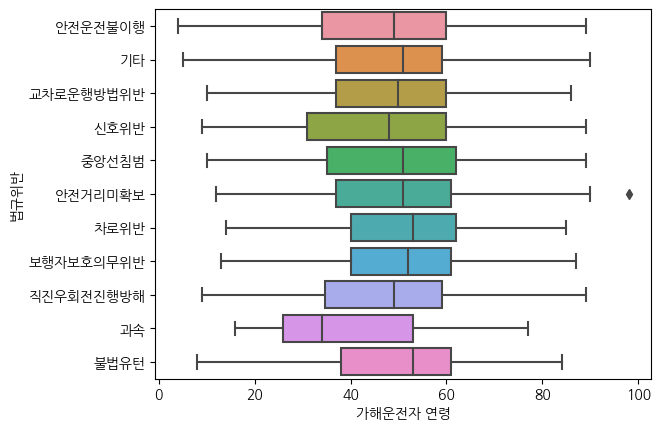

In [ ]:
sns.boxplot(data=train, y='법규위반', x='가해운전자 연령')
plt.show()

## 가해운전자, 피해운전자의 연령에 따른 ECLO  

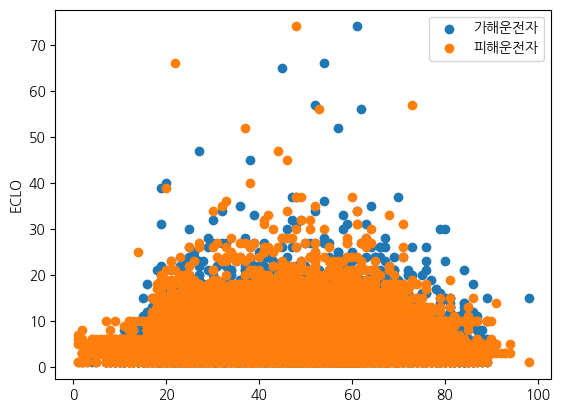

In [ ]:
plt.scatter(x=train['가해운전자 연령'],y=train['ECLO'])
plt.ylabel("ECLO");

plt.scatter(x=train['피해운전자 연령'],y=train['ECLO'])
plt.ylabel("ECLO");
plt.legend(['가해운전자','피해운전자']);

## 시간에 따른 ECLO

In [ ]:
train['년도'] = pd.to_datetime(train['사고일시']).dt.year
train['월'] = pd.to_datetime(train['사고일시']).dt.month
train['일'] = pd.to_datetime(train['사고일시']).dt.day
train['시간'] = pd.to_datetime(train['사고일시']).dt.hour

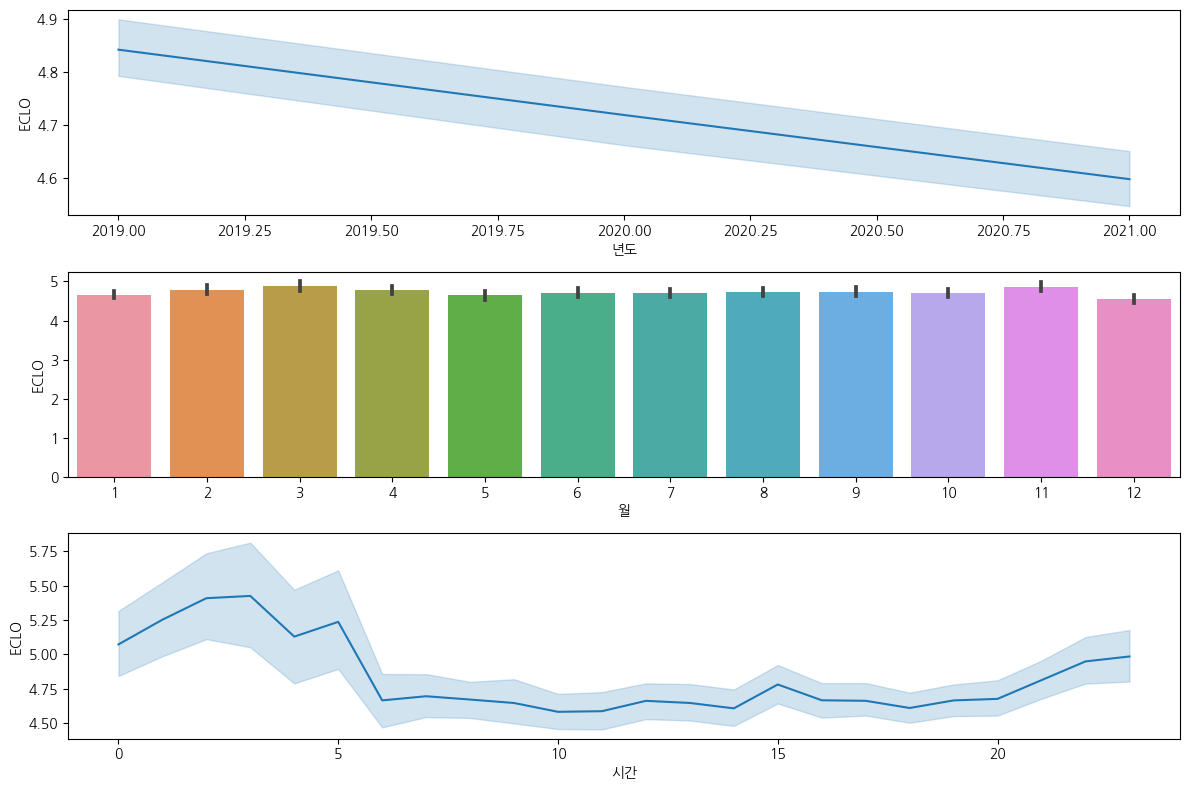

In [ ]:
plt.figure(figsize=(12,8))
plt.subplot(3,1,1)
#가정 1. 년도가 증가할수록 교통사고는 낮을 것이다.
sns.lineplot(data=train, x='년도', y='ECLO')
plt.subplot(3,1,2)
#가정 2. 공휴일이 있는 월에 ECLO가 높을 것이다.
sns.barplot(data=train, x='월', y='ECLO')
plt.subplot(3,1,3)
#가정 3. 출퇴근 시간에 ECLO가 높을 것이다.
sns.lineplot(data=train, x='시간', y='ECLO')
plt.tight_layout();

#상관관계 분석

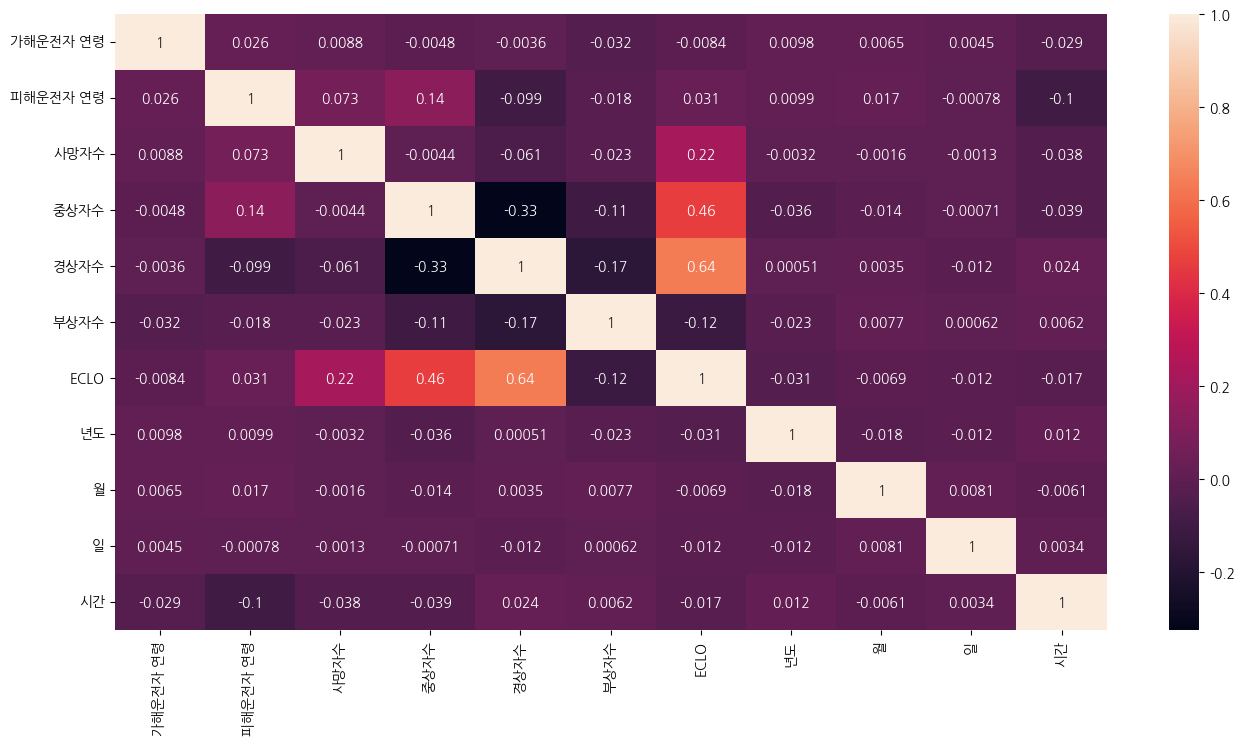

In [ ]:
plt.figure(figsize=(16,8))
sns.heatmap(train.corr(), annot=True);

In [ ]:
%reset -f

In [ ]:
!pip install mljar-supervised

In [ ]:
import pandas as pd
import numpy as np
import random
import os
from sklearn.preprocessing import LabelEncoder
from supervised import AutoML
import numpy as np

path = '/content/drive/MyDrive/[Dacon]/대구 교통사고 피해 예측 AI 경진대회/open/open'

train_df = pd.read_csv(path + '/train.csv')
test_df = pd.read_csv(path + '/test.csv')

In [ ]:
train_df['사고일시'] = pd.to_datetime(train_df['사고일시'])

In [ ]:
test_df['사고일시'] = pd.to_datetime(test_df['사고일시'])

# 시/ 군/ 구 split

In [ ]:
import pandas as pd

def process_address(df):

    def split_address(address):
        elements = address.split(" ")
        return elements[1:3] if len(elements) == 3 else ['', '']

    address_parts = df['시군구'].apply(split_address)
    df['군'], df['구'] = zip(*address_parts)

    return df

train_df = process_address(train_df)
test_df = process_address(test_df)

# 외부 데이터 사용

In [ ]:
# 외부 데이터 사용을 위함 함수
def load_and_preprocessing(file_path, col, drop_col, location_pattern, cnt_col=None ,dummies = False, drop_dupli = False):
    df = pd.read_csv(file_path,encoding='cp949')[col]
    if drop_dupli:
        df = pd.read_csv(file_path,encoding='cp949').drop_duplicates()[col]
        df[cnt_col] = 1
    if dummies:
        df = pd.get_dummies(df, columns=['급지구분'])

    df[['도시', '군', '구', '번지']] = df['소재지지번주소'].str.extract(location_pattern)
    df = df.drop(columns = drop_col)
    df = df.groupby(['군', '구']).sum().reset_index()

    df.reset_index(inplace=True, drop=True)
    return df

In [ ]:
location_pattern = r'(\S+) (\S+) (\S+) (\S+)'
# 보안등
light_df = load_and_preprocessing('/content/drive/MyDrive/[Dacon]/대구 교통사고 피해 예측 AI 경진대회/open/open/external_open/대구 보안등 정보.csv',['설치개수', '소재지지번주소'],['도시','소재지지번주소', '번지'],location_pattern)

# 주차장
parking_df = load_and_preprocessing('/content/drive/MyDrive/[Dacon]/대구 교통사고 피해 예측 AI 경진대회/open/open/external_open/대구 주차장 정보.csv',['소재지지번주소', '급지구분'],['도시','소재지지번주소', '번지'],location_pattern,dummies = True)

# 어린이 보호구역
child_area_df = load_and_preprocessing('/content/drive/MyDrive/[Dacon]/대구 교통사고 피해 예측 AI 경진대회/open/open/external_open/대구 어린이 보호 구역 정보.csv',['소재지지번주소'],['도시','소재지지번주소', '번지'],location_pattern,'child_cnt',drop_dupli=True)

# # cctv
# cctv_info = load_and_preprocessing('external_open\대구 CCTV 정보.csv',['소재지지번주소'],['도시','소재지지번주소', '번지'],location_pattern,'cctv_cnt',drop_dupli=True)

In [ ]:
cctv = pd.read_csv('/content/drive/MyDrive/[Dacon]/대구 교통사고 피해 예측 AI 경진대회/open/open/external_open/대구 CCTV 정보.csv',encoding='cp949')

In [ ]:
# 속도
cctv_1 = cctv.loc[cctv['단속구분'] == 1]
# 신호
cctv_2 = cctv.loc[cctv['단속구분'] == 2]
# 불법주정차
cctv_4 = cctv.loc[cctv['단속구분'] == 4]
# 기타
cctv_99 = cctv.loc[cctv['단속구분'] == 99]

In [ ]:
def process_cctv_data(df, cnt_col_name):
    df = df.drop_duplicates()[['소재지지번주소']]
    df[cnt_col_name] = 1
    df[['도시', '군', '구', '번지']] = df['소재지지번주소'].str.extract(location_pattern)
    df = df.drop(columns=['도시', '소재지지번주소', '번지'])
    df = df.groupby(['군', '구']).sum().reset_index()
    df.reset_index(inplace=True, drop=True)
    return df

# 각 cctv 데이터프레임에 함수 적용
cctv_1 = process_cctv_data(cctv_1, 'cnt1_col')
cctv_2 = process_cctv_data(cctv_2, 'cnt2_col')
cctv_4 = process_cctv_data(cctv_4, 'cnt4_col')
cctv_99 = process_cctv_data(cctv_99, 'cnt99_col')


In [ ]:
def merge_dataframes(base_df, dfs_to_merge, merge_on):
    for df in dfs_to_merge:
        base_df = pd.merge(base_df, df, how='left', on=merge_on)
    return base_df

# 사용 예시
train_df = merge_dataframes(train_df, [light_df, child_area_df, parking_df,cctv_1,cctv_2,cctv_4,cctv_99], ['군', '구'])
test_df = merge_dataframes(test_df, [light_df, child_area_df, parking_df,cctv_1,cctv_2,cctv_4,cctv_99], ['군', '구'])

# 결과 확인
print(train_df.head())
print(test_df.head())


               ID                사고일시   요일 기상상태            시군구      도로형태 노면상태  \
0  ACCIDENT_00000 2019-01-01 00:00:00  화요일   맑음   대구광역시 중구 대신동  단일로 - 기타   건조   
1  ACCIDENT_00001 2019-01-01 00:00:00  화요일   흐림  대구광역시 달서구 감삼동  단일로 - 기타   건조   
2  ACCIDENT_00002 2019-01-01 01:00:00  화요일   맑음  대구광역시 수성구 두산동  단일로 - 기타   건조   
3  ACCIDENT_00003 2019-01-01 02:00:00  화요일   맑음   대구광역시 북구 복현동  단일로 - 기타   건조   
4  ACCIDENT_00004 2019-01-01 04:00:00  화요일   맑음   대구광역시 동구 신암동  단일로 - 기타   건조   

   사고유형 사고유형 - 세부분류     법규위반  ...    구    설치개수 child_cnt 급지구분_1 급지구분_2 급지구분_3  \
0  차대사람  길가장자리구역통행중  안전운전불이행  ...  대신동   391.0       2.0   11.0    0.0    0.0   
1  차대사람       보도통행중       기타  ...  감삼동   932.0       NaN    0.0    1.0    3.0   
2  차대사람       차도통행중  안전운전불이행  ...  두산동   473.0       5.0    NaN    NaN    NaN   
3   차대차          추돌  안전운전불이행  ...  복현동   534.0      11.0    0.0    9.0    5.0   
4   차대차          추돌  안전운전불이행  ...  신암동  2057.0       NaN    0.0    1.0    0.0   

  cnt1_col cnt2_col  cnt4_

## Label encoding

# 시군구별 발생횟수 feature 추가

In [ ]:
accident_counts = train_df['시군구'].value_counts().reset_index()
accident_counts.columns = ['시군구', '사고횟수']

In [ ]:
# '시군구'별 사고 횟수를 train_df에 매핑하기 위해 '시군구' 컬럼을 기준으로 사고 횟수를 가져옵니다.
train_df['사고발생횟수'] = train_df['시군구'].map(accident_counts.set_index('시군구')['사고횟수'])


In [ ]:
# '시군구'별 사고 횟수를 train_df에 매핑하기 위해 '시군구' 컬럼을 기준으로 사고 횟수를 가져옵니다.
test_df['사고발생횟수'] = test_df['시군구'].map(accident_counts.set_index('시군구')['사고횟수'])


In [ ]:
# datetime 컬럼 처리
train_df['사고일시'] = pd.to_datetime(train_df['사고일시'])
test_df['사고일시'] = pd.to_datetime(test_df['사고일시'])

# datetime을 여러 파생 변수로 변환
for df in [train_df, test_df]:
    df['year'] = df['사고일시'].dt.year
    df['month'] = df['사고일시'].dt.month
    df['day'] = df['사고일시'].dt.day
    df['hour'] = df['사고일시'].dt.hour
    df['minute'] = df['사고일시'].dt.minute

In [ ]:
holi_weekday = ['2019-01-01', '2019-02-04', '2019-02-05', '2019-02-06', '2019-03-01', '2019-05-05', '2019-05-12', '2019-06-06', '2019-08-15', '2019-09-12', '2019-09-13', '2019-09-14', '2019-10-03', '2019-10-09', '2019-12-25',
                '2020-01-01' ,'2020-01-24' ,'2020-01-25', '2020-01-26', '2020-03-01', '2020-04-30', '2020-05-05', '2020-06-06', '2020-08-15', '2020-08-17', '2020-09-30', '2020-10-01', '2020-10-02', '2020-10-03', '2020-10-09', '2020-12-25',
                '2021-01-01' ,'2021-02-11' ,'2021-02-12', '2021-02-13', '2021-03-01', '2021-05-05', '2021-05-19', '2021-06-06', '2021-08-15', '2021-09-20', '2021-09-21', '2021-09-22', '2021-10-03', '2021-10-09', '2021-12-25',
                '2022-01-01' ,'2022-01-31' ,'2022-02-01', '2022-02-02', '2022-03-01', '2022-05-05', '2022-05-08', '2022-06-06', '2022-08-15', '2022-09-09', '2022-09-10', '2022-09-11', '2022-09-12', '2022-10-03', '2022-10-09', '2020-10-10', '2022-12-25','2023-01-01' , '2023-03-01']

In [ ]:
train_df['사고일시'] = pd.to_datetime(train_df['사고일시'])
train_df['day_of_week'] = train_df['사고일시'].dt.dayofweek
train_df['holiday'] = np.where((train_df.day_of_week >= 5) | (train_df.사고일시.dt.strftime('%Y-%m-%d').isin(holi_weekday)), 1, 0)

In [ ]:
test_df['사고일시'] = pd.to_datetime(test_df['사고일시'])
test_df['day_of_week'] = test_df['사고일시'].dt.dayofweek
test_df['holiday'] = np.where((test_df.day_of_week >= 5) | (test_df.사고일시.dt.strftime('%Y-%m-%d').isin(holi_weekday)), 1, 0)

# 파생변수 추가

In [ ]:
def classify_time(hour):

    if 6 <= hour <= 11:
        return  0 #"아침"
    elif 12 <= hour <= 15:
        return 1 # "점심"
    elif 16 <= hour <= 21:
        return 2 #"저녁"
    else:
        return 3 #"새벽"

train_df['time_category'] = train_df['hour'].apply(classify_time)
test_df['time_category'] = test_df['hour'].apply(classify_time)

def classify_weather(month):

    if  month in [12,1,2]:
        return  0 #"겨울"
    elif month in [3,4,5]:
        return 1 # "봄"
    elif month in [6,7,8]:
        return 2 #"여름"
    else:
        return 3 #"가을"
train_df['weather'] = train_df['month'].apply(classify_time)
test_df['weather'] = test_df['month'].apply(classify_time)

def classify_rush_hour(hour):
    if (7<=hour<=9) or (17<=hour<=19):
        return 1
    else:
        return 0

train_df['rush_hour'] = train_df['hour'].apply(classify_rush_hour)
test_df['rush_hour'] = test_df['hour'].apply(classify_rush_hour)

train_df['Cosine_Time'] = np.cos(2 * np.pi * train_df['hour'] / 24)
test_df['Cosine_Time'] = np.cos(2 * np.pi * test_df['hour'] / 24)

# Target-Encoding

In [ ]:
# Target encoding
from category_encoders.target_encoder import TargetEncoder

categorical_features = ['ID','시군구','요일','도로형태','사고유형','구','기상상태', '노면상태','군']

for i in categorical_features:
    tr_encoder = TargetEncoder(cols=[i])
    train_df[i] = tr_encoder.fit_transform(train_df[i], train_df['ECLO'])
    test_df[i] = tr_encoder.transform(test_df[i])

# 지울 변수 지우기

In [ ]:
drop_col = ['ID','year', 'month','day', 'hour', 'minute','사고일시','요일','시군구']
target = train_df['ECLO']
train_df = train_df.drop(columns = drop_col+list(set(train_df.columns) - set(test_df.columns)))
test_df = test_df.drop(columns = drop_col)

### AUTOML

In [ ]:
import matplotlib
matplotlib.use('Agg')

In [ ]:
from supervised.automl import AutoML
automl = AutoML(
    mode="Compete",
    algorithms=['Random Forest', 'LightGBM', 'Xgboost', 'CatBoost','Neural Network','Extra Trees'],
    n_jobs=-1,
    total_time_limit=43200,
    eval_metric="rmse",
    ml_task="regression",
    features_selection=True,  # 특성 선택 활성화
    boost_on_errors=True,     # 오류에 대한 부스팅 활성화
    # 기타 필요한 설정들...
)

In [ ]:
automl.fit(train_df, target)

There was an error during 9_Xgboost training.
Please check AutoML_5/errors.md for details.
There was an error during 27_CatBoost training.
Please check AutoML_5/errors.md for details.
There was an error during 36_RandomForest training.
Please check AutoML_5/errors.md for details.
There was an error during 45_ExtraTrees training.
Please check AutoML_5/errors.md for details.
There was an error during 54_NeuralNetwork training.
Please check AutoML_5/errors.md for details.
There was an error during 19_LightGBM training.
Please check AutoML_5/errors.md for details.
There was an error during 10_Xgboost training.
Please check AutoML_5/errors.md for details.
There was an error during 28_CatBoost training.
Please check AutoML_5/errors.md for details.
There was an error during 37_RandomForest training.
Please check AutoML_5/errors.md for details.
There was an error during 46_ExtraTrees training.
Please check AutoML_5/errors.md for details.
There was an error during 55_NeuralNetwork training.
Ple

ImportError: ignored

In [ ]:
pred = automl.predict(test_df)

## 제출

In [ ]:
submission = pd.read_csv('sample_submission.csv')

In [ ]:
submission['ECLO'] = pred

In [ ]:
submission.loc[ submission['ECLO'] < 0.0, 'ECLO'] = 0.0

In [ ]:
submission.to_csv('1208_v3.csv', index=False)